In [9]:
# UltraFast 모델 standalone 테스트용
# 위치: /home/kiwi/github_package/rokeypj_ws/src/turtlebot3_autorace_detect/turtlebot3_autorace_detect/ufld_test.ipynb

import os
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torchvision

### ---- 통합된 backbone ----

class resnet(torch.nn.Module):
    def __init__(self, layers, pretrained=False):
        super(resnet, self).__init__()
        if layers == '18':
            model = torchvision.models.resnet18(pretrained=pretrained)
        elif layers == '34':
            model = torchvision.models.resnet34(pretrained=pretrained)
        else:
            raise NotImplementedError

        self.conv1 = model.conv1
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x2 = self.layer2(x)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        return x2, x3, x4

### ---- 통합된 model ----

class parsingNet(torch.nn.Module):
    def __init__(self, size=(288, 800), pretrained=True, backbone='18', cls_dim=(37, 18, 2)):
        super(parsingNet, self).__init__()

        self.size = size
        self.w = size[0]
        self.h = size[1]
        self.cls_dim = cls_dim
        self.total_dim = np.prod(cls_dim)

        self.model = resnet(backbone, pretrained=pretrained)
        self.cls = torch.nn.Sequential(
            torch.nn.Linear(1800, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, self.total_dim),
        )
        self.pool = torch.nn.Conv2d(512, 8, 1)

    def forward(self, x):
        x2, x3, fea = self.model(x)
        fea = self.pool(fea).view(-1, 1800)
        group_cls = self.cls(fea).view(-1, *self.cls_dim)
        return group_cls

### ---- UltraFastLaneDetector 테스트용 ----

class UltraFastLaneTester:
    def __init__(self):
        self.backbone = '18'
        self.griding_num = 37
        self.cls_num_per_lane = 18
        self.num_lanes = 2

        # weight 경로 지정 (ROS 경로 제거)
        model_path = '/home/kiwi/github_package/rokeypj_ws/src/turtlebot3_autorace_detect/turtlebot3_autorace_detect/model/tusimple_18.pth'

        self.net = parsingNet(size=(288, 800), backbone=self.backbone,
                               cls_dim=(self.griding_num, self.cls_num_per_lane, self.num_lanes))

        # weight 로딩: fc layer 제외하고 로딩
        state_dict = torch.load(model_path, map_location='cpu')
        for key in list(state_dict['model'].keys()):
            if 'cls' in key:
                del state_dict['model'][key]

        self.net.load_state_dict(state_dict['model'], strict=False)
        self.net.eval()

        self.transform = transforms.Compose([
            transforms.Resize((288, 800)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                  [0.229, 0.224, 0.225])
        ])

    def infer(self, bgr_img):
        img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        img_input = self.transform(img_pil).unsqueeze(0)

        with torch.no_grad():
            output = self.net(img_input)

        output = output.cpu().numpy()[0]
        out = np.argmax(output, axis=2)

        col_sample = np.linspace(0, 800 - 1, self.griding_num)

        lanes_x = []
        for lane_idx in range(self.num_lanes):
            lane = out[lane_idx]
            lane_pos = []
            for i in range(self.cls_num_per_lane):
                if lane[i] < self.griding_num:
                    x = col_sample[lane[i]]
                    lane_pos.append(x)
                else:
                    lane_pos.append(-1)
            lanes_x.append(lane_pos)

        return lanes_x

    def visualize(self, bgr_img, lanes_x):
        vis = bgr_img.copy()
        h, w, _ = vis.shape
        for lane in lanes_x:
            for idx, x in enumerate(lane):
                if x > 0:
                    y = int(h * (idx + 1) / self.cls_num_per_lane)
                    cv2.circle(vis, (int(x * w / 800), y), 3, (0, 255, 0), -1)
        return vis


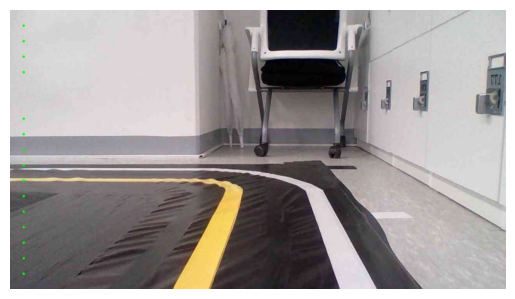

In [12]:
# UltraFastLaneTester 클래스 불러오기

tester = UltraFastLaneTester()

# 테스트 이미지 불러오기 (경로 수정)
img_path = '/home/kiwi/github_package/rokeypj_ws/src/turtlebot3_autorace_camera/turtlebot3_autorace_camera/saved_img/saved_image_20250617_212916.jpg'
# img_path = '/home/kiwi/Downloads/photo-1486673748761-a8d18475c757.jpeg'
# img_path = '/home/kiwi/Downloads/road2.jpg'

bgr_img = cv2.imread(img_path)

lanes_x = tester.infer(bgr_img)
vis_img = tester.visualize(bgr_img, lanes_x)

# 시각화
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
